In [45]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import time
import numpy as np
from load_data_and_distribution_analisys import split_dataset_v1, plot_confusion_matrix, load_data

# Feature engeneering con pca

In questo notebook viene effettuato lo stesso test fatto nel notebook `other_classifiers_with_pca`, con l'aggiunta del feature engeneering.  
Riteniamo sia un test necessario da fare visto che tramite feature engeneering abbiamo aumentato il numero delle feature totali all'interno del dataset; inoltre abbiamo testato già che il solo utilizzo delle nuove feature non ha migliorato le performance dei nostri modelli, dunque tramite PCA possiamo provare ad estrarre pattern più significativi. Avremmo potuto anche fare feature selection dopo aver aggiunto queste nuove feature, però abbiamo ritenuto che il rapporto risultati/tempo impiegato per fare feature selection, non sarebbe stato vantaggioso.

In [46]:
dataset = load_data()

Path to dataset files: /Users/marcodeano/.cache/kagglehub/datasets/sooyoungher/smoking-drinking-dataset/versions/2


## Features antropometriche

In [47]:
dataset['BMI'] = dataset['weight'] / (dataset['height'] / 100) ** 2
dataset['wth_ratio'] = dataset['waistline'] / dataset['height']
dataset['wtw_ratio'] = dataset['waistline'] / dataset['weight']
dataset['obesity_flag'] = (dataset['BMI'] >= 30).astype(int)

## Features cardiovascolari

In [48]:
def bp_category(row):
    if row['SBP'] < 120 and row['DBP'] < 80:
        return 'Normal'
    elif row['SBP'] < 140 and row['DBP'] < 90:
        return 'Prehypertensive'
    else:
        return 'Hypertensive'

dataset['pulse_pressure'] = dataset['SBP'] - dataset['DBP']
dataset['MAP'] = (2 * dataset['DBP'] + dataset['SBP']) / 3
dataset['bp_category'] = dataset.apply(bp_category, axis=1)

## Profilo lipidico e rapporti metabolici

In [49]:
dataset['TC_HDL_ratio'] = dataset['tot_chole'] / dataset['HDL_chole']
dataset['LDL_HDL_ratio'] = dataset['LDL_chole'] / dataset['HDL_chole']                              
dataset['non_HDL_chole'] = dataset['tot_chole'] - dataset['HDL_chole']
dataset['triglyceride_hdl_ratio'] = dataset['triglyceride'] / dataset['HDL_chole']      

dataset["AIP"] = np.log10(dataset['triglyceride'] / dataset['HDL_chole'])

dataset['TyG'] = np.log(dataset['triglyceride'] * dataset['BLDS'] / 2)                   

## Features inerenti la funzione epatica e renale

In [50]:
def calc_eGFR(row):
    # Using the CKD-EPI formula from 2009
    # https://doi.org/10.7326/0003-4819-150-9-200905050-00006

    SCr = row['serum_creatinine']
    age = row['age']
    is_female = row['sex'] == 'Female'
    
    k = 0.7 if is_female else 0.9
    a = -0.329 if is_female else -0.411

    eGFR = 141 * min(SCr / k, 1) ** a * max(SCr / k, 1) ** (-1.209) * 0.993 ** age
    eGFR *= 1.018 if is_female else 1

    return eGFR

dataset['AST_ALT_ratio'] = dataset['SGOT_AST'] / dataset['SGOT_ALT']
dataset['liver_enzyme_avg'] = (dataset['SGOT_AST'] + dataset['SGOT_ALT'] + dataset['gamma_GTP']) / 3
dataset['eGFR'] = dataset.apply(calc_eGFR, axis=1)

In [51]:
label_encoders = {}

for column in dataset.columns:
    if dataset[column].dtype == 'object':
        label_encoders[column] = LabelEncoder()
        dataset[column] = label_encoders[column].fit_transform(dataset[column])

In [52]:
dataset.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN,BMI,wth_ratio,wtw_ratio,obesity_flag,pulse_pressure,MAP,bp_category,TC_HDL_ratio,LDL_HDL_ratio,non_HDL_chole,triglyceride_hdl_ratio,AIP,TyG,AST_ALT_ratio,liver_enzyme_avg,eGFR
0,1,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,80.0,99.0,193.0,48.0,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,1,25.951557,0.529412,1.200000,0,40.0,93.333333,2,4.020833,2.625000,145.0,1.916667,0.282547,8.423761,0.600000,32.000000,97.078265
1,1,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,82.0,106.0,228.0,55.0,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,0,24.691358,0.494444,1.112500,0,48.0,98.000000,2,4.145455,2.690909,173.0,2.200000,0.342423,8.766082,0.555556,27.666667,114.208011
2,1,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,70.0,98.0,136.0,41.0,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,0,27.548209,0.551515,1.213333,0,50.0,86.666667,2,3.317073,1.804878,95.0,2.536585,0.404249,8.536211,1.468750,49.000000,106.460635
3,1,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,87.0,95.0,201.0,76.0,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,0,26.122449,0.520000,1.137500,0,58.0,106.333333,0,2.644737,1.368421,125.0,1.394737,0.144492,8.524169,0.852941,27.000000,77.860462
4,1,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,82.0,101.0,199.0,61.0,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,0,22.038567,0.484848,1.333333,0,56.0,100.666667,2,3.262295,1.918033,138.0,1.704918,0.231704,8.566364,1.583333,18.666667,104.161020


# Predizioni

In [53]:
X_smoke, y_smoke, X_drink, y_drink = split_dataset_v1(dataset)

In [ ]:
pipelines = {
    "svm": Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=0.95)), ("svm", LinearSVC(random_state=42, C=0.1, class_weight="balanced"))]),
    "knn": Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=0.95 )), ("knn", KNeighborsClassifier(n_neighbors=500, n_jobs=-1))]),
}

In [55]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_drink, y_drink, test_size=0.2, random_state=42, stratify=y_drink)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_smoke, y_smoke, test_size=0.2, random_state=42, stratify=y_smoke)

### Drinking

In [56]:
for name, pipeline in pipelines.items():
    print(f"Training {name}...", end=" ")
    t0 = time.time()

    pipeline.fit(X_train_d, y_train_d)  
    
    print(f"took {time.time() - t0:.2f} seconds")

Training svm... took 2.94 seconds
Training knn... took 0.49 seconds


Classification report per svm:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72     99172
           1       0.72      0.72      0.72     99098

    accuracy                           0.72    198270
   macro avg       0.72      0.72      0.72    198270
weighted avg       0.72      0.72      0.72    198270



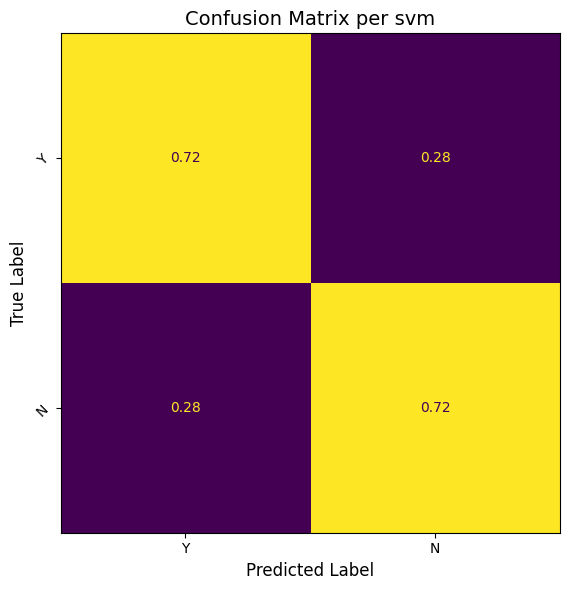

Classification report per knn:
              precision    recall  f1-score   support

           0       0.73      0.68      0.70     99172
           1       0.70      0.75      0.72     99098

    accuracy                           0.71    198270
   macro avg       0.71      0.71      0.71    198270
weighted avg       0.71      0.71      0.71    198270



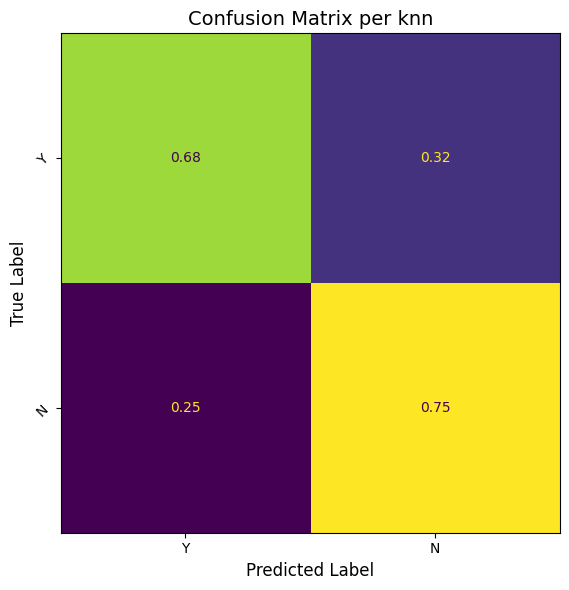

In [57]:
for name, pipeline in pipelines.items():
    y_pred_drink = pipeline.predict(X_test_d)

    report_drink = classification_report(y_test_d, y_pred_drink)

    print(f"Classification report per {name}:")
    print(report_drink)

    plot_confusion_matrix(y_test_d, y_pred_drink, ["Y", "N"], f"Confusion Matrix per {name}")

### Smoking

In [58]:
for name, pipeline in pipelines.items():
    print(f"Training {name}...", end=" ")
    t0 = time.time()

    pipeline.fit(X_train_s, y_train_s)  
    
    print(f"took {time.time() - t0:.2f} seconds")

Training svm... took 11.86 seconds
Training knn... took 0.42 seconds


Classification report per svm:
              precision    recall  f1-score   support

         1.0       0.89      0.76      0.82    120489
         2.0       0.41      0.44      0.43     34990
         3.0       0.48      0.63      0.54     42791

    accuracy                           0.68    198270
   macro avg       0.59      0.61      0.60    198270
weighted avg       0.71      0.68      0.69    198270



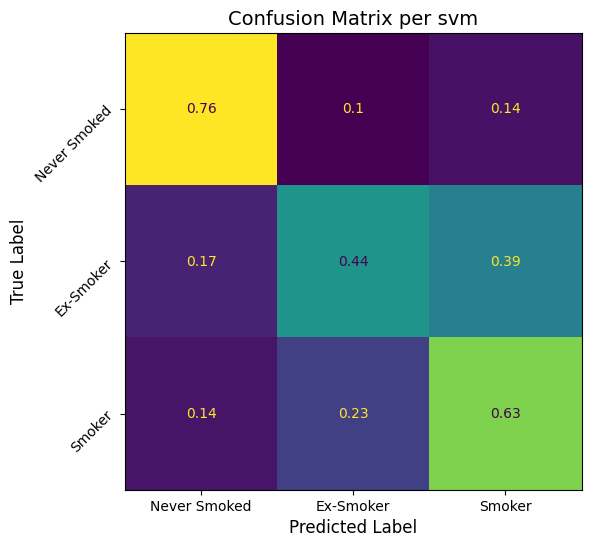

Classification report per knn:
              precision    recall  f1-score   support

         1.0       0.82      0.82      0.82    120489
         2.0       0.43      0.34      0.38     34990
         3.0       0.49      0.57      0.53     42791

    accuracy                           0.68    198270
   macro avg       0.58      0.58      0.58    198270
weighted avg       0.68      0.68      0.68    198270



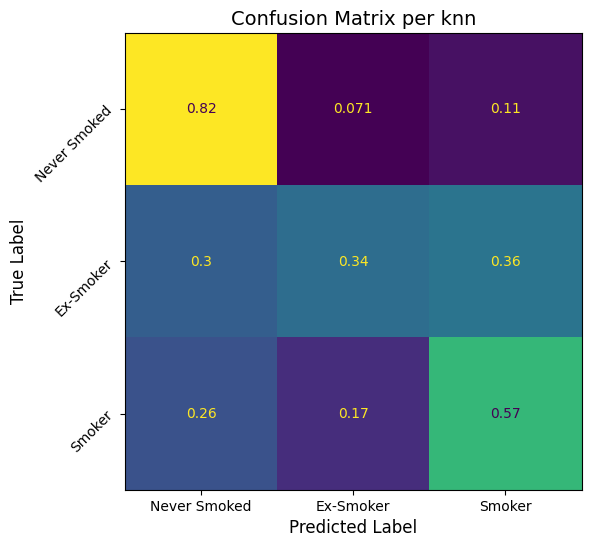

In [59]:
for name, pipeline in pipelines.items():
    y_pred_smoke = pipeline.predict(X_test_s)

    report_smoke = classification_report(y_test_s, y_pred_smoke)

    print(f"Classification report per {name}:")
    print(report_smoke)

    plot_confusion_matrix(y_test_s, y_pred_smoke, ["Never Smoked", "Ex-Smoker", "Smoker"], f"Confusion Matrix per {name}")